In [1]:
%matplotlib inline

import json
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy

In [2]:
plt.style.use('../style/style-formal.mplstyle')

In [3]:
def create_FL_dataframe(score_file):
    with open(score_file, 'r') as f:
        data = json.load(f)

    rows = []
    buggy_method_ranks = data["buggy_methods"]
    for bug_name in buggy_method_ranks:
        autofl_ranks = [
            buggy_method_ranks[bug_name][m]["autofl_rank"]
            for m in buggy_method_ranks[bug_name]
        ]
        if len(autofl_ranks) == 0:
            continue
        AP = np.mean([(i+1)/r for i, r in enumerate(sorted(autofl_ranks))])
        if AP > 1:
            print(autofl_ranks)
            print(AP)
        rows.append([bug_name, data["confidence"][bug_name]] \
                    + [1 in autofl_ranks, 1/min(autofl_ranks), AP])

    df = pd.DataFrame(
        data=rows,
        columns=["bug_name", "confidence"] \
            + ["P@1", "RR", "AP"])
    return df

def spearmanr_corr_with_confidence(df):
    from scipy.stats import spearmanr
    metrics = ["P@1", "RR", "AP"]
    corr_df = pd.DataFrame(data=[
        (m, corr.statistic, corr.pvalue)
        for m in metrics
        if (corr := spearmanr(df["confidence"], df[m]))
    ], columns=["metric", "spearman correlation coefficient", "p-value"])
    return corr_df

def draw_metric_distributions(df, metrics=["P@1", "RR", "AP"],
                              confidence_col="confidence", savepath=None):
    plt.figure(figsize=(9, 2))
    for i, m in enumerate(metrics):
        plt.subplot(1, len(metrics), i+1)
        threshold_ranges = [
            (0.0, 0.2), (0.2, 0.4), (0.4, 0.6), (0.6, 0.8), (0.8, 1.0)
        ]
        if m == "P@1":
            vi = plt.bar(range(1, len(threshold_ranges)+1), [
                    df[(df[confidence_col] >= r[0]) & (df[confidence_col] < r[1])][m].mean() if r[1] != 1.0
                    else df[(df[confidence_col] >= r[0]) & (df[confidence_col] <= r[1])][m].mean()
                    for r in threshold_ranges
                ], zorder=100)
            plt.title(f"Ratio of {m}")
        else:
            vi = plt.violinplot([
                    df[(df[confidence_col] >= r[0]) & (df[confidence_col] < r[1])][m] if r[1] != 1.0
                    else df[(df[confidence_col] >= r[0]) & (df[confidence_col] <= r[1])][m]
                    for r in threshold_ranges
                ],
                showmeans=True, showextrema=False)

            plt.title(f"Distributions of {m}")

            for partname in ('cbars','cmins','cmaxes','cmeans','cmedians'):
                if partname not in vi:
                    continue
                vp = vi[partname]
                vp.set_linewidth(1)
        plt.ylim([0, 1])
        plt.ylabel(None)
        plt.xticks(range(1, len(threshold_ranges) +1),
                [f"[{r[0]}, {r[1]}" + (")" if r[1] != 1 else "]") for r in threshold_ranges],
                rotation=45)

    if savepath:
        plt.savefig(savepath, bbox_inches="tight")
    plt.show()

def draw_PR_curve(dfs, showF1=True, savepath=None, figsize=(7,3), title="Precision-Recall Curve for Precision@1 Prediction"):
    from sklearn.metrics import precision_recall_curve, auc
    if not isinstance(dfs, dict):
        dfs = {"original": dfs}
    plt.figure(figsize=figsize)
    markers = ['o', 'v', '^', '<', '>', '8', 's']
    for i, name in enumerate(dfs):
        df = dfs[name]
        precision, recall, thresholds = precision_recall_curve(df["P@1"], df["confidence"])
        f1 = 2 * (precision * recall) / (precision + recall)
        best_f1_idx = f1.argmax()
        auc_value = auc(recall, precision)
        plt.plot(recall, precision, label=f"{name} (AUC={auc_value:.3f})")
        if showF1:
            plt.scatter(recall[best_f1_idx], precision[best_f1_idx], zorder=100,
                        label=f"best f1={f1[best_f1_idx]:.2f} (thresh.={thresholds[best_f1_idx]:.2f})",
                        marker=markers[i])

    if title is not None:
        plt.title(title)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend()
    if savepath:
        plt.savefig(savepath, bbox_inches="tight")
    plt.show()

# RQ2: Accuracy of FL Confidence Estimation

,metric,spearman correlation coefficient,p-value
0,P@1,0.57,0.0
1,RR,0.67,0.0
2,AP,0.70,0.0


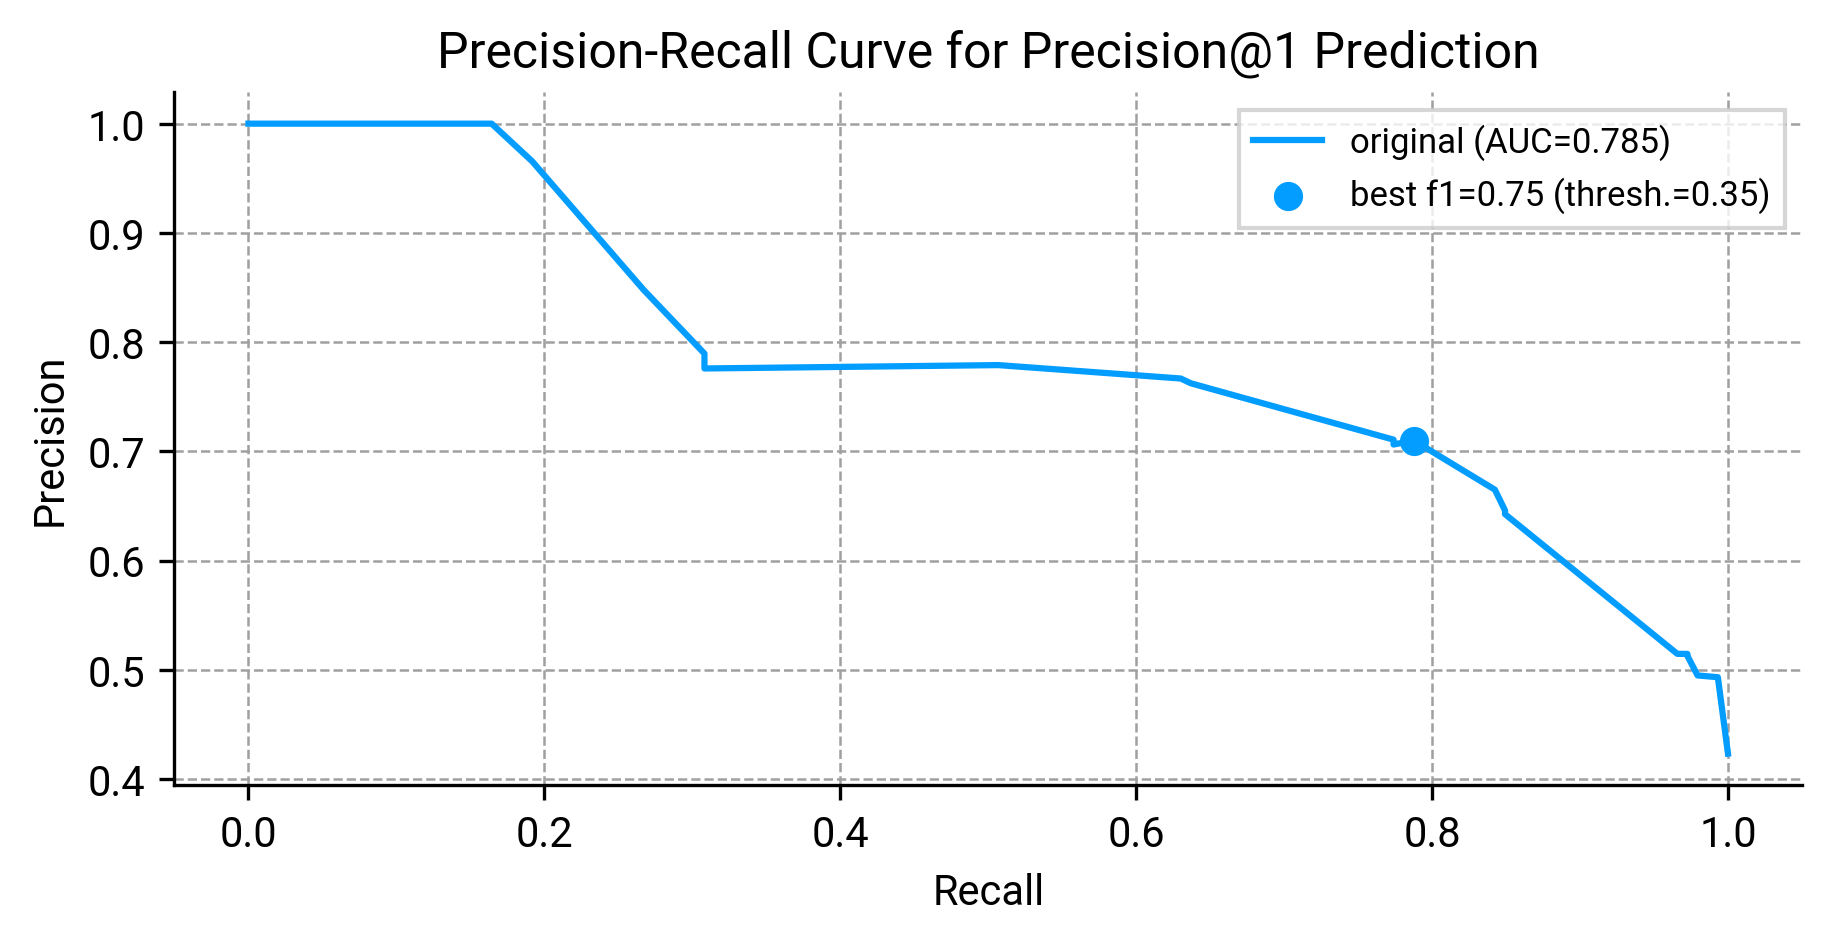

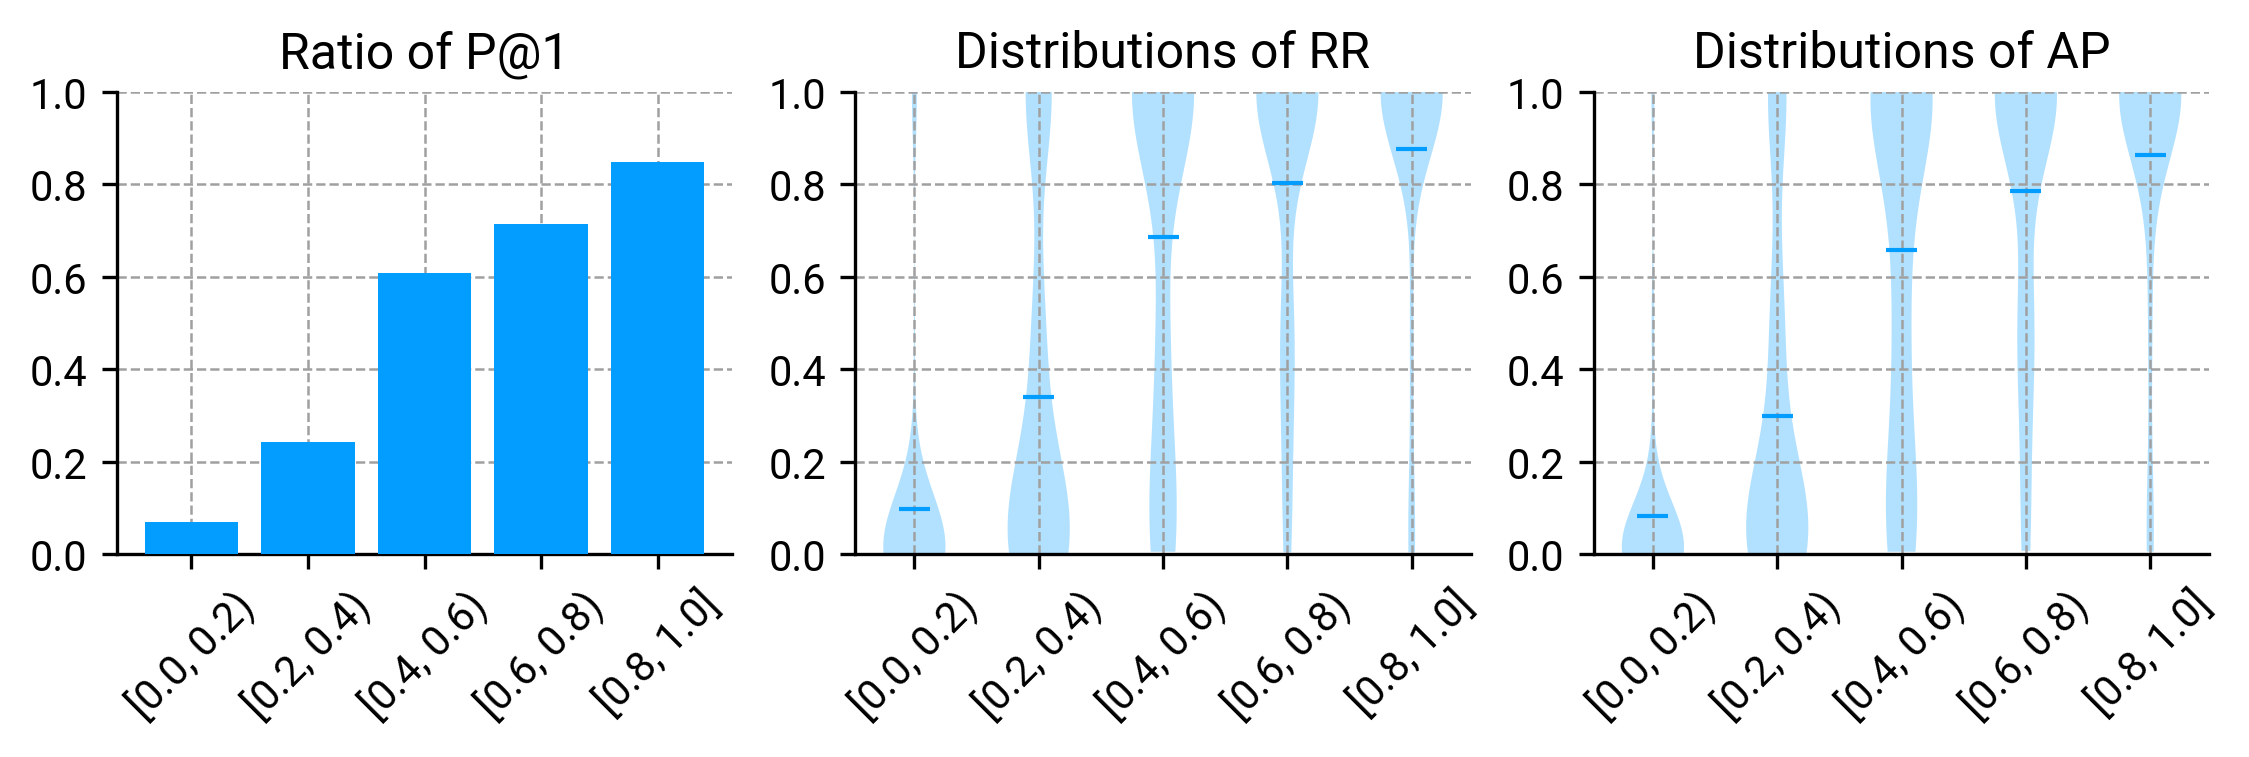

In [4]:
# Defects4J
D4J_df = create_FL_dataframe("../combined_fl_results/d4j_gpt3_results_R5.json")
D4J_corr_df = spearmanr_corr_with_confidence(D4J_df)
display(D4J_corr_df.round(2))
draw_PR_curve(D4J_df)
draw_metric_distributions(D4J_df, savepath="./figures/RQ2_D4J_conf_distributions.pdf")

,metric,spearman correlation coefficient,p-value
0,P@1,0.52,0.0
1,RR,0.50,0.0
2,AP,0.49,0.0


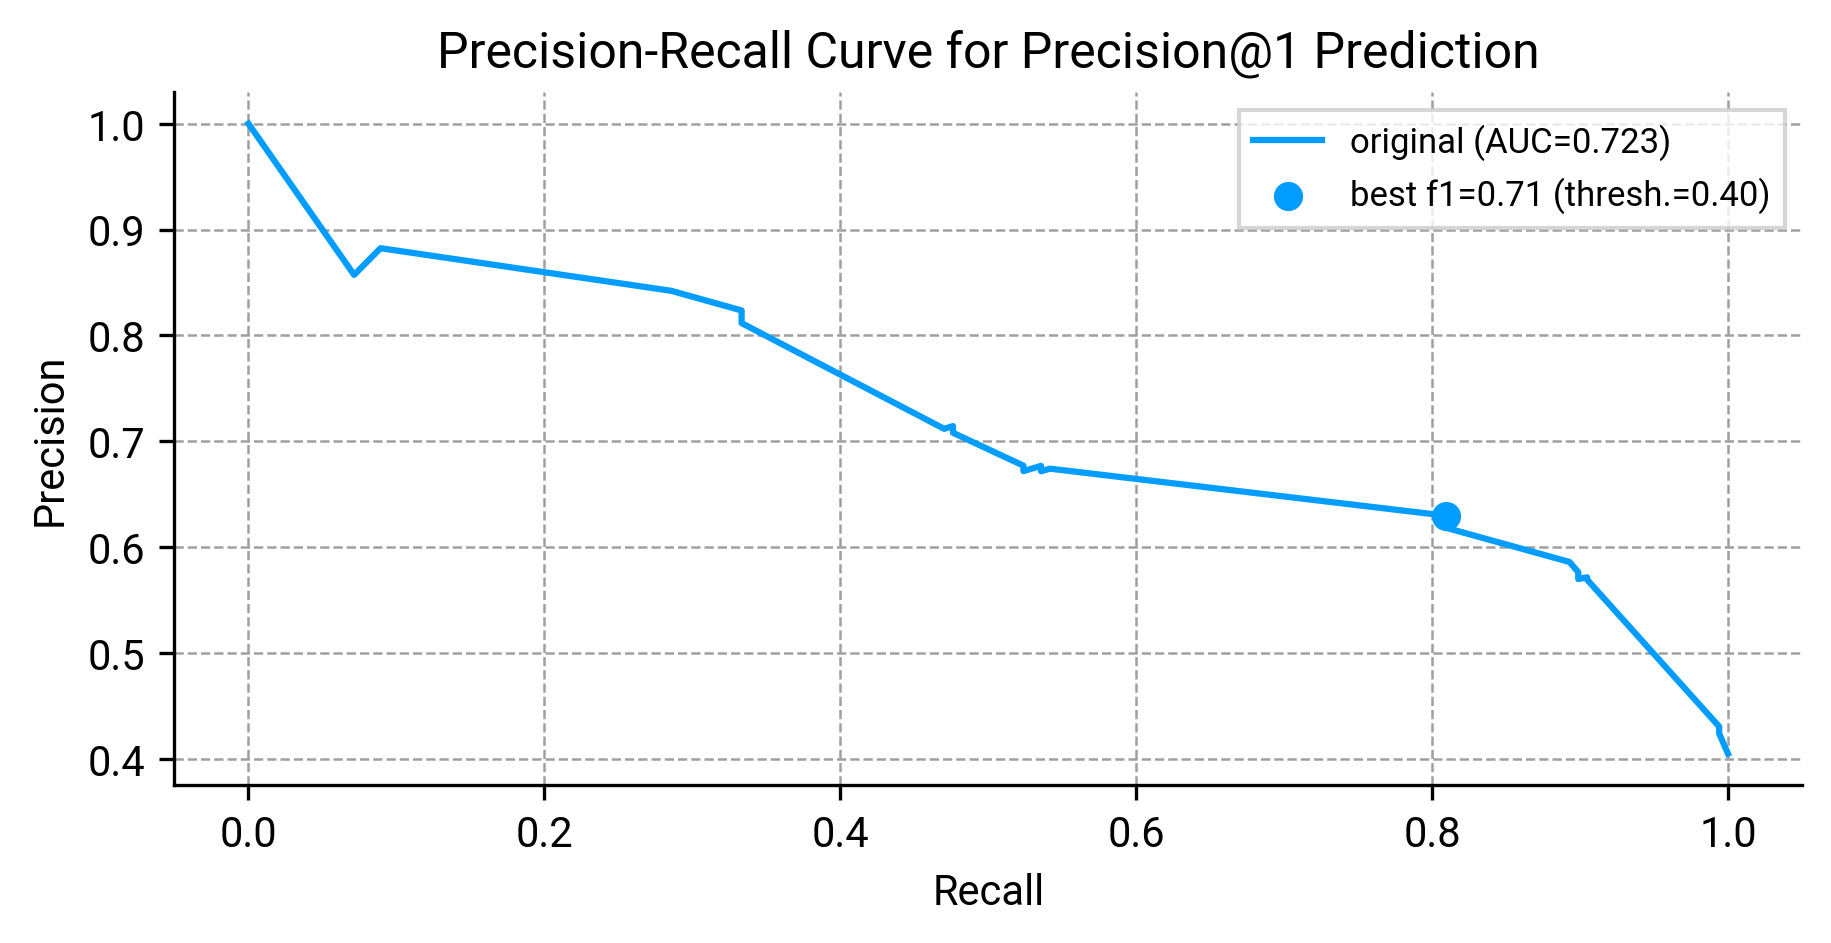

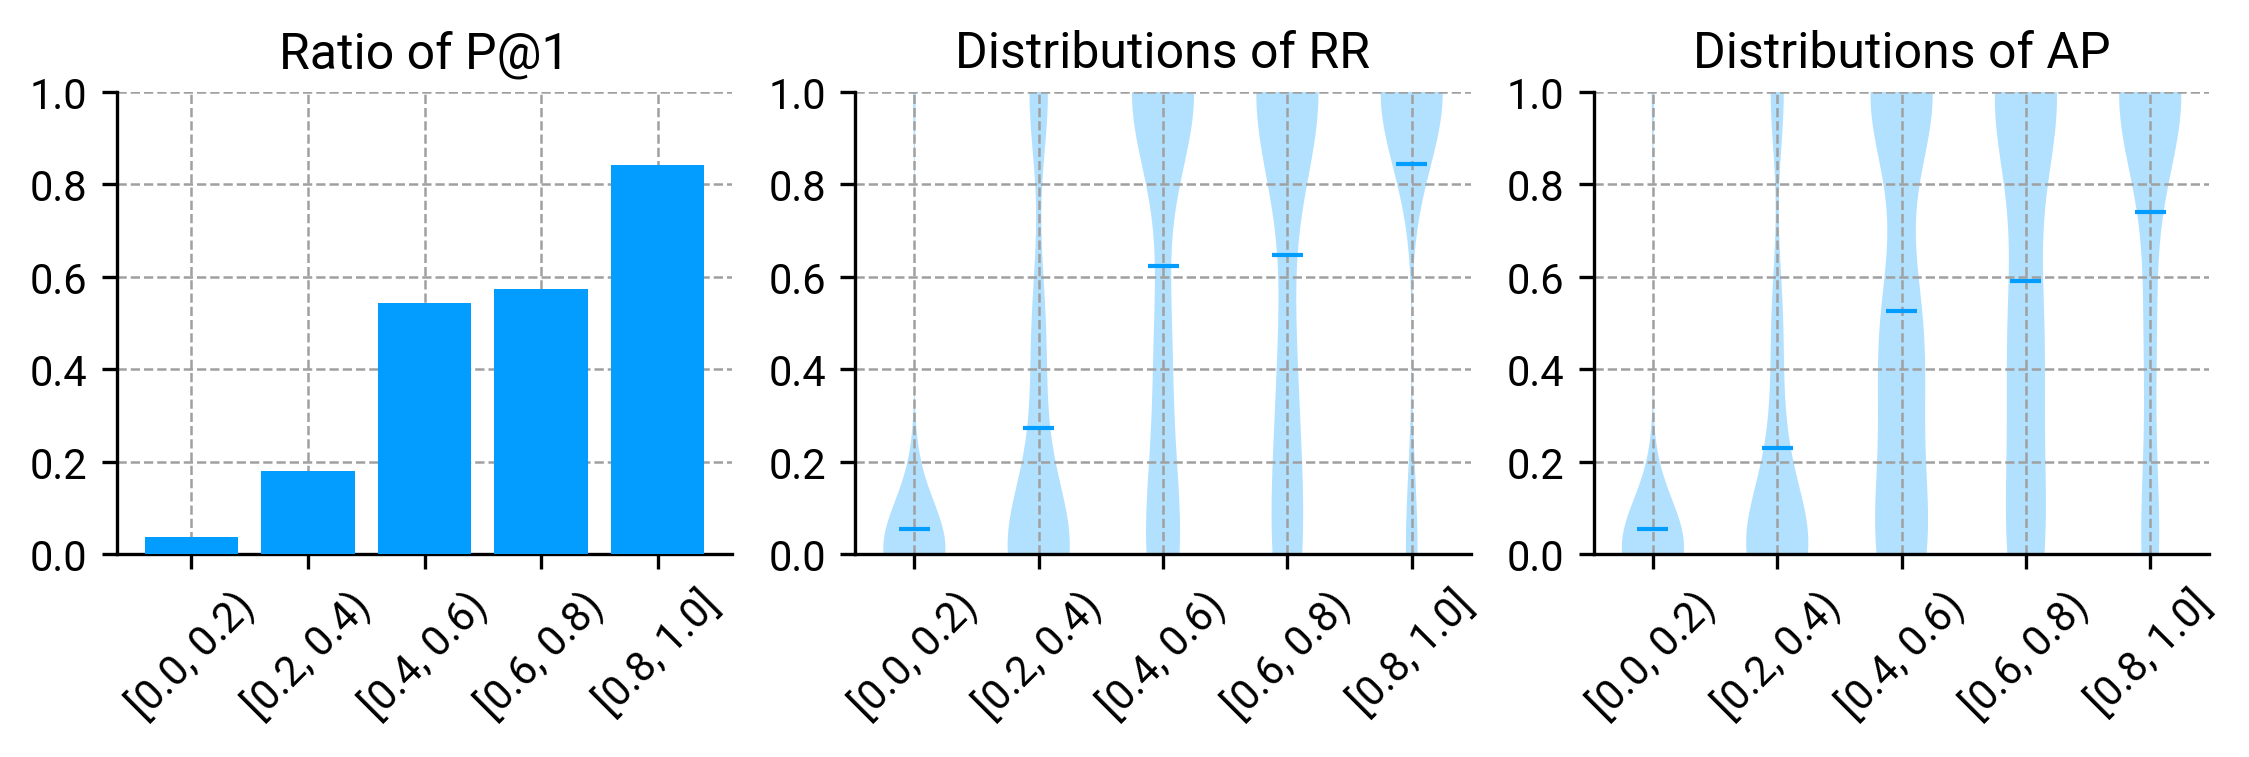

In [5]:
#BugsInPy
BIP_df = create_FL_dataframe("../combined_fl_results/bip_gpt3_results_R5.json")
BIP_corr_df = spearmanr_corr_with_confidence(BIP_df)
display(BIP_corr_df.round(2))
draw_PR_curve(BIP_df)
draw_metric_distributions(BIP_df, savepath="./figures/RQ2_BIP_conf_distributions.pdf")